# Import

In [ ]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import copy 
import time
from scipy import stats
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import multiprocessing


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Dataset

### Import dataset

In [ ]:
filepath = "/content/comb_df_vpeak.csv" #@param {type: "string"}
df=pd.read_csv(filepath, sep=',')

le = LabelEncoder()
df["type.num"] = le.fit_transform(df["cell.type"])
map = dict(zip(le.classes_, le.transform(le.classes_)))
print(df["cell.type"].value_counts())
print(map)

X_column = 'VLF|VMF' #@param ['VLF|VMF','VLF|VMF|VHF']
X = df.filter(regex=(X_column))
y = df["type.num"]

U937        8870
SUM159PT    4688
M0          3959
BEAD10      2706
MCF7        2705
J365         979
Name: cell.type, dtype: int64
{'BEAD10': 0, 'J365': 1, 'M0': 2, 'MCF7': 3, 'SUM159PT': 4, 'U937': 5}


### Preprocessing


1.   Split between test and train
2.   Normalize X_train and X_test



In [ ]:
#@title Split dataset { run: "auto" }
split_percentage = 0.3 #@param {type:"slider", min:0, max:1, step:0.05}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_percentage, stratify=y, random_state=0)

#### Normalisation

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Machine Learning Model

## Function plot

In [ ]:
list_model_train = []

In [ ]:
def find_best_config(list_model,name):
  index = 0
  best_score = 0
  for i in list_model:
    if i.best_score_ > best_score:
      best_score = i.best_score_
      index = list_model.index(i)
  best_model = list_model[index]
  list_model_train.append([best_model,name])

In [ ]:
def print_model_train(list_model_train):
  for i in list_model_train:
    model = i[0]
    name = i[1]
    t0 = time.time()
    validation = model.predict(X_test)
    predict_time = round(time.time() - t0, 5)
    confusion_matrix_value = confusion_matrix(y_test, validation)
    confusion_matrix_normalized = confusion_matrix_value.astype('float') / confusion_matrix_value.sum(axis=1)[:, np.newaxis]
    confusion_matrix_withlabel = pd.DataFrame(confusion_matrix_normalized,
                                          index = [*map],
                                          columns = [*map])
    plt.figure(figsize=(20,10))
    ax = sns.heatmap(confusion_matrix_withlabel, cmap="Blues", annot=confusion_matrix_value, fmt='g')
    plt.title(f'Confusion Matrix -- {name}')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    print(f'\nBest param : {model.best_params_}')
    print(f'Prediction time : {predict_time}')
    print(f'Accuracy : {accuracy_score(y_test, validation)}\n')
    print(f'{classification_report(y_test, validation)}\n')
    print_factor_influence(model)
    print('\n')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def print_factor_influence(model):
    result = pd.DataFrame(model.cv_results_)
    means_test = result['mean_test_score']
    masks=[]
    masks_names = list(model.best_params_.keys())
    for p_k, p_v in model.best_params_.items():
      if (p_v == None):
        result['param_'+p_k] = result['param_'+p_k].fillna(value = -1)
        p_v = -1
      masks.append(list(result['param_'+p_k] == p_v))
    
    try:
      params=model.param_grid[0]
    except:
      params=model.param_grid
    
    if len(params) > 1:
      fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
      fig.suptitle('Influence des paramètres sur les scores')
      fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical') 
      for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        if (p == "hidden_layer_sizes"):
          for i in range(len(x)):
            string = ""
            for j in x[i]:
              string += f'{str(j)} '
            x[i] = string
        try:
          ax[i].plot(x, y_1, linestyle='--', marker='o', label='mean_test_score')
          ax[i].set_xlabel(p.upper())
        except:
          x = np.where(x == None, "None", x)
          ax[i].plot(x, y_1, linestyle='--', marker='o', label='mean_test_score')
          ax[i].set_xlabel(p.upper())
    
    else:
      param_name = 'param_' + masks_names[0]
      x = np.array(result[param_name])
      y = np.array(means_test)
      plt.figure(figsize=(6.5,3))
      plt.plot(x, y, linestyle='--', marker='o', label='mean_test_score')
      plt.title('Influence des paramètres sur les scores')
      plt.xlabel(param_name)
      plt.ylabel('MEAN SCORE')

    plt.legend()
    plt.show()

## Recherche param SVM

In [ ]:
param_grid1 = {'C': [0.1, 1, 10,100, 500, 1000, 5000, 10000, 20000],
              'gamma': ["scale", "auto", 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ["rbf"]}

param_grid2 = {'C': [0.1, 0.5],
              'gamma': ["scale", "auto", 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ["poly"]}

param_grid3 = {'C' : [0.1, 1, 10],
               'gamma': ["scale", "auto", 1, 0.1, 0.01, 0.001, 0.0001],
               'kernel': ["linear"]}

param_grid = [param_grid1, param_grid2, param_grid3]
list_model_svm = []

for i in param_grid:
  grid = GridSearchCV(estimator = SVC(), cv = 3, param_grid = i, refit = True, verbose = 3)
  grid.fit(X_train, y_train)
  list_model_svm += [copy.deepcopy(grid)]

find_best_config(list_model_svm,"SVM")

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV 1/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.710 total time=   5.7s
[CV 2/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.725 total time=   5.7s
[CV 3/3] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.718 total time=   5.5s
[CV 1/3] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.711 total time=   5.6s
[CV 2/3] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.725 total time=   5.7s
[CV 3/3] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.718 total time=   5.7s
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.746 total time=   4.9s
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.756 total time=   4.9s
[CV 3/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.752 total time=   5.0s
[CV 1/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.690 total time=   6.6s
[CV 2/3] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.698 total time=   6.6s
[CV 3/3] END ......C=0.1, gamma=0.1, kernel=rbf

## Recherche param LogReg

In [ ]:
param_grid1 = {"C": np.logspace(-4, 4, 50),
               "penalty": ["l2"],
               "solver" : ["lbfgs", "newton-cg"],
               "max_iter" : [10000]}

param_grid = [param_grid1]
list_model_logreg = []

for i in param_grid:
  grid = GridSearchCV(estimator = LogisticRegression(), cv = 3, param_grid = i, refit = True, verbose = 3)
  grid.fit(X_train, y_train)
  list_model_logreg += [copy.deepcopy(grid)]

find_best_config(list_model_logreg,"LogReg")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END C=0.0001, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.385 total time=   0.1s
[CV 2/3] END C=0.0001, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.385 total time=   0.1s
[CV 3/3] END C=0.0001, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.386 total time=   0.1s
[CV 1/3] END C=0.0001, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.385 total time=   0.4s
[CV 2/3] END C=0.0001, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.385 total time=   0.7s
[CV 3/3] END C=0.0001, max_iter=10000, penalty=l2, solver=newton-cg;, score=0.386 total time=   0.4s
[CV 1/3] END C=0.00014563484775012445, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.389 total time=   0.1s
[CV 2/3] END C=0.00014563484775012445, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.386 total time=   0.1s
[CV 3/3] END C=0.00014563484775012445, max_iter=10000, penalty=l2, solver=lbfgs;, score=0.389 total time=   0.1s
[CV 

## Recherche param random forest

In [ ]:
param_grid1 = { 
    'n_estimators': [10, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 8, 10, 30, 50, None],
    'criterion' :['gini', 'entropy']
}

param_grid = [param_grid1]
list_model_randomForest = []

for i in param_grid:
  grid = GridSearchCV(estimator = RandomForestClassifier(random_state=42), cv = 3, param_grid = i, refit = True, verbose = 3)
  grid.fit(X_train, y_train)
  list_model_randomForest += [copy.deepcopy(grid)]

find_best_config(list_model_randomForest,"RandomForest")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3] END criterion=gini, max_depth=5, max_features=auto, n_estimators=10;, score=0.719 total time=   0.1s
[CV 2/3] END criterion=gini, max_depth=5, max_features=auto, n_estimators=10;, score=0.730 total time=   0.1s
[CV 3/3] END criterion=gini, max_depth=5, max_features=auto, n_estimators=10;, score=0.730 total time=   0.1s
[CV 1/3] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.724 total time=   1.2s
[CV 2/3] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.734 total time=   1.2s
[CV 3/3] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.730 total time=   1.2s
[CV 1/3] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.723 total time=   2.4s
[CV 2/3] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.734 total time=   2.3s
[CV 3/3] END criterion=gini, max_depth=5, max_featur

## Recherche param decision tree

In [ ]:
param_grid1 = { 
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth' : [5, 8, 9, 10, 30, 50, None],
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
}

param_grid = [param_grid1]
list_model_decisionTree = []

for i in param_grid:
  grid = GridSearchCV(estimator = DecisionTreeClassifier(), cv = 3, param_grid = i, refit = True, verbose = 3)
  grid.fit(X_train, y_train)
  list_model_decisionTree += [copy.deepcopy(grid)]

find_best_config(list_model_decisionTree,"DecisionTree")

Fitting 3 folds for each of 112 candidates, totalling 336 fits
[CV 1/3] END criterion=gini, max_depth=5, max_features=auto, splitter=best;, score=0.694 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=5, max_features=auto, splitter=best;, score=0.718 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=5, max_features=auto, splitter=best;, score=0.688 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=5, max_features=auto, splitter=random;, score=0.595 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=5, max_features=auto, splitter=random;, score=0.563 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=5, max_features=auto, splitter=random;, score=0.612 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=5, max_features=sqrt, splitter=best;, score=0.701 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=5, max_features=sqrt, splitter=best;, score=0.714 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=5, max_features=sqrt, splitt

## Recherche param KNN

In [ ]:
param_grid1 = { 
    'n_neighbors': list(range(1, 31)),
    'weights': ["uniform", "distance"],
    'algorithm': ["auto"]
}

param_grid = [param_grid1]
list_model_knn = []

for i in param_grid:
  grid = GridSearchCV(estimator = KNeighborsClassifier(), cv = 3, param_grid = i, refit = True, verbose = 3)
  grid.fit(X_train, y_train)
  list_model_knn += [copy.deepcopy(grid)]

find_best_config(list_model_knn,"Knn")

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END algorithm=auto, n_neighbors=1, weights=uniform;, score=0.793 total time=   0.1s
[CV 2/3] END algorithm=auto, n_neighbors=1, weights=uniform;, score=0.792 total time=   0.1s
[CV 3/3] END algorithm=auto, n_neighbors=1, weights=uniform;, score=0.789 total time=   0.2s
[CV 1/3] END algorithm=auto, n_neighbors=1, weights=distance;, score=0.793 total time=   0.0s
[CV 2/3] END algorithm=auto, n_neighbors=1, weights=distance;, score=0.792 total time=   0.0s
[CV 3/3] END algorithm=auto, n_neighbors=1, weights=distance;, score=0.789 total time=   0.0s
[CV 1/3] END algorithm=auto, n_neighbors=2, weights=uniform;, score=0.764 total time=   0.1s
[CV 2/3] END algorithm=auto, n_neighbors=2, weights=uniform;, score=0.759 total time=   0.1s
[CV 3/3] END algorithm=auto, n_neighbors=2, weights=uniform;, score=0.755 total time=   0.1s
[CV 1/3] END algorithm=auto, n_neighbors=2, weights=distance;, score=0.793 total time=   0.0s
[CV 

## Recherche param GNB

In [ ]:
param_grid1 = { 
    'var_smoothing': np.logspace(0,-11, num=100)
}

param_grid = [param_grid1]
list_model_gnb = []

for i in param_grid:
  grid = GridSearchCV(estimator = GaussianNB(), cv = 3, param_grid = param_grid, refit = True, verbose = 3)
  grid.fit(X_train, y_train)
  list_model_gnb += [copy.deepcopy(grid)]

find_best_config(list_model_gnb,"GNB")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END .................var_smoothing=1.0;, score=0.535 total time=   0.0s
[CV 2/3] END .................var_smoothing=1.0;, score=0.548 total time=   0.0s
[CV 3/3] END .................var_smoothing=1.0;, score=0.547 total time=   0.0s
[CV 1/3] END ..var_smoothing=0.7742636826811271;, score=0.544 total time=   0.0s
[CV 2/3] END ..var_smoothing=0.7742636826811271;, score=0.546 total time=   0.0s
[CV 3/3] END ..var_smoothing=0.7742636826811271;, score=0.548 total time=   0.0s
[CV 1/3] END ...var_smoothing=0.599484250318941;, score=0.545 total time=   0.0s
[CV 2/3] END ...var_smoothing=0.599484250318941;, score=0.547 total time=   0.0s
[CV 3/3] END ...var_smoothing=0.599484250318941;, score=0.551 total time=   0.0s
[CV 1/3] END ..var_smoothing=0.4641588833612779;, score=0.546 total time=   0.0s
[CV 2/3] END ..var_smoothing=0.4641588833612779;, score=0.549 total time=   0.0s
[CV 3/3] END ..var_smoothing=0.464158883361277

## Recherche param MLP

In [ ]:
param_grid1 = { 
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.1, 1],
    'learning_rate': ['constant','adaptive'],
}

param_grid = [param_grid1]
list_model_gnb = []

for i in param_grid:
  grid = GridSearchCV(estimator = MLPClassifier(max_iter = 5000, tol=0.001), cv = 3, param_grid = i, refit = True, verbose = 3)
  grid.fit(X_train, y_train)
  list_model_gnb += [copy.deepcopy(grid)]

find_best_config(list_model_gnb,"MLP")

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd;, score=0.792 total time=  27.3s
[CV 2/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd;, score=0.793 total time=  24.8s
[CV 3/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd;, score=0.791 total time=  35.0s
[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam;, score=0.864 total time=  33.9s
[CV 2/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam;, score=0.855 total time=  32.4s
[CV 3/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam;, score=0.855 total time=  30.1s
[CV 1/3] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(5

## Print Model

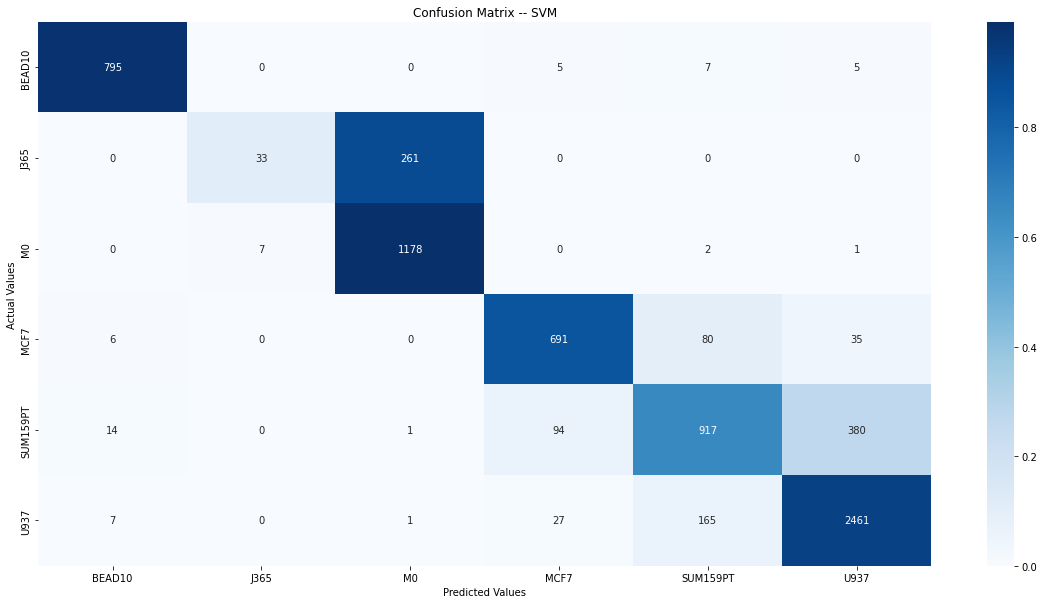


Best param : {'C': 20000, 'gamma': 1, 'kernel': 'rbf'}
Prediction time : 2.26949
Accuracy : 0.8469259723964868

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       812
           1       0.82      0.11      0.20       294
           2       0.82      0.99      0.90      1188
           3       0.85      0.85      0.85       812
           4       0.78      0.65      0.71      1406
           5       0.85      0.92      0.89      2661

    accuracy                           0.85      7173
   macro avg       0.85      0.75      0.75      7173
weighted avg       0.84      0.85      0.83      7173




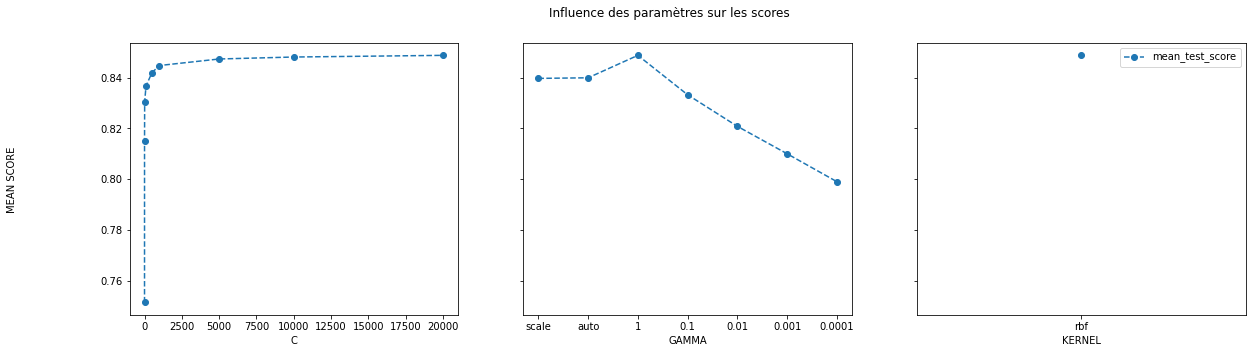

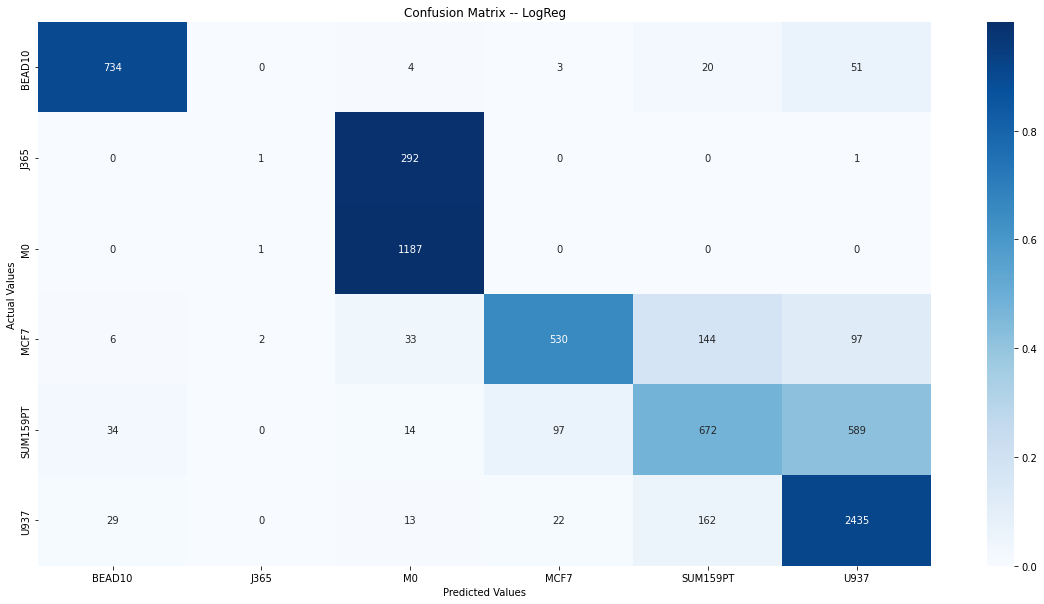


Best param : {'C': 494.1713361323828, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Prediction time : 0.00246
Accuracy : 0.7749895441237976

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       812
           1       0.25      0.00      0.01       294
           2       0.77      1.00      0.87      1188
           3       0.81      0.65      0.72       812
           4       0.67      0.48      0.56      1406
           5       0.77      0.92      0.83      2661

    accuracy                           0.77      7173
   macro avg       0.70      0.66      0.65      7173
weighted avg       0.75      0.77      0.75      7173




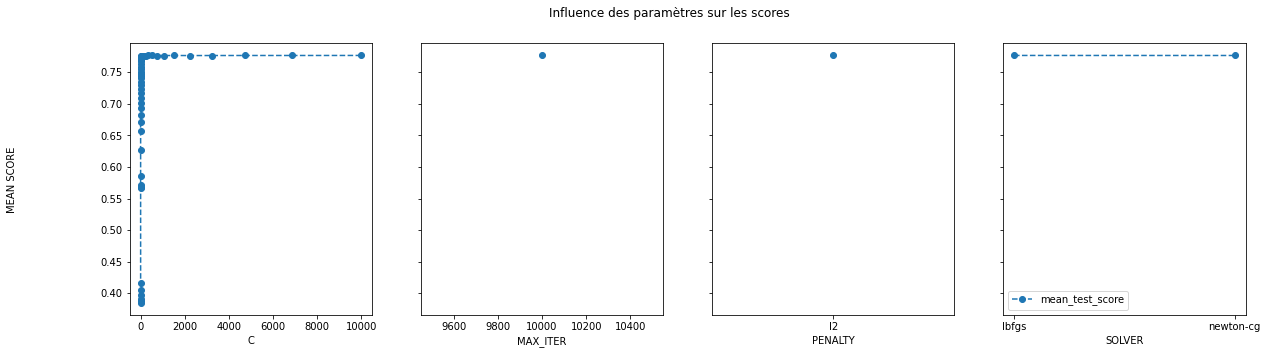

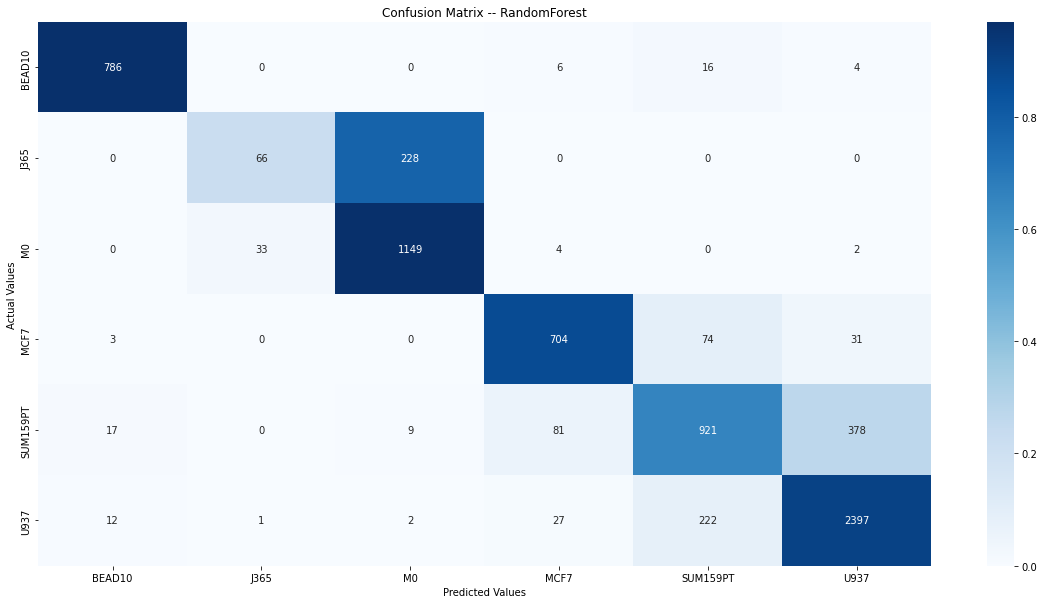


Best param : {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 200}
Prediction time : 0.34669
Accuracy : 0.8396765648961383

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       812
           1       0.66      0.22      0.34       294
           2       0.83      0.97      0.89      1188
           3       0.86      0.87      0.86       812
           4       0.75      0.66      0.70      1406
           5       0.85      0.90      0.88      2661

    accuracy                           0.84      7173
   macro avg       0.82      0.76      0.77      7173
weighted avg       0.83      0.84      0.83      7173




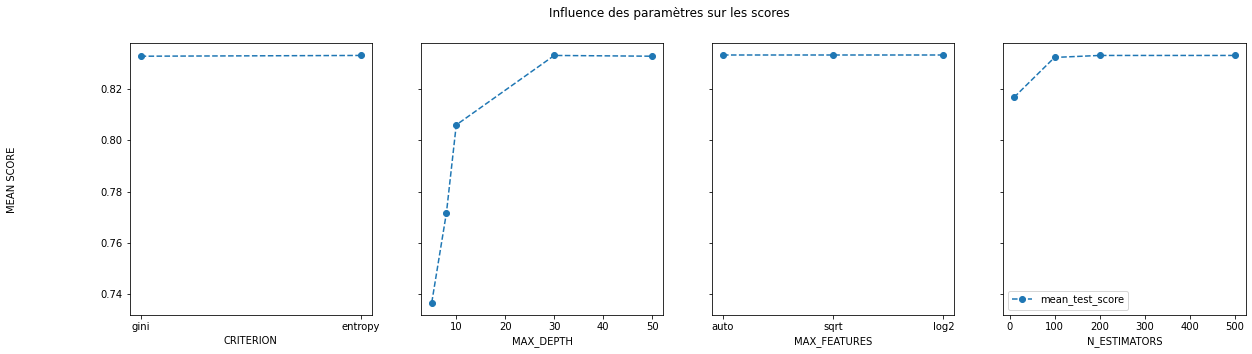

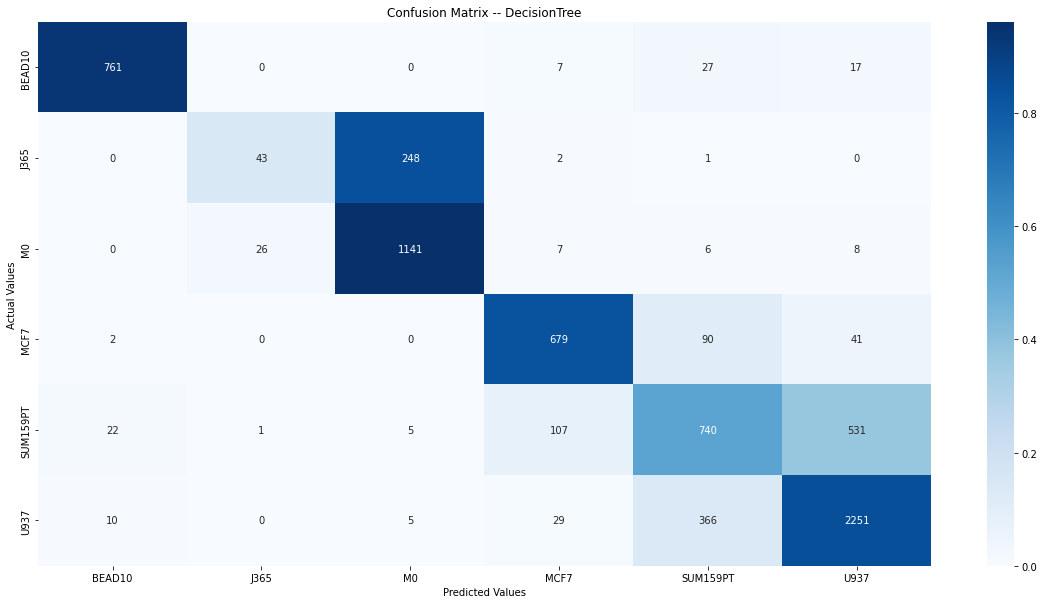


Best param : {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'splitter': 'best'}
Prediction time : 0.00357
Accuracy : 0.7827965983549422

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       812
           1       0.61      0.15      0.24       294
           2       0.82      0.96      0.88      1188
           3       0.82      0.84      0.83       812
           4       0.60      0.53      0.56      1406
           5       0.79      0.85      0.82      2661

    accuracy                           0.78      7173
   macro avg       0.77      0.71      0.71      7173
weighted avg       0.77      0.78      0.77      7173




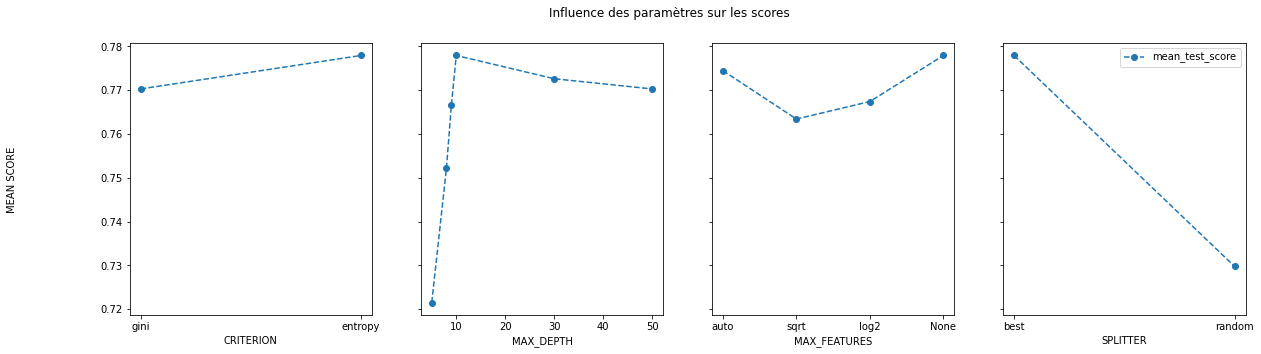

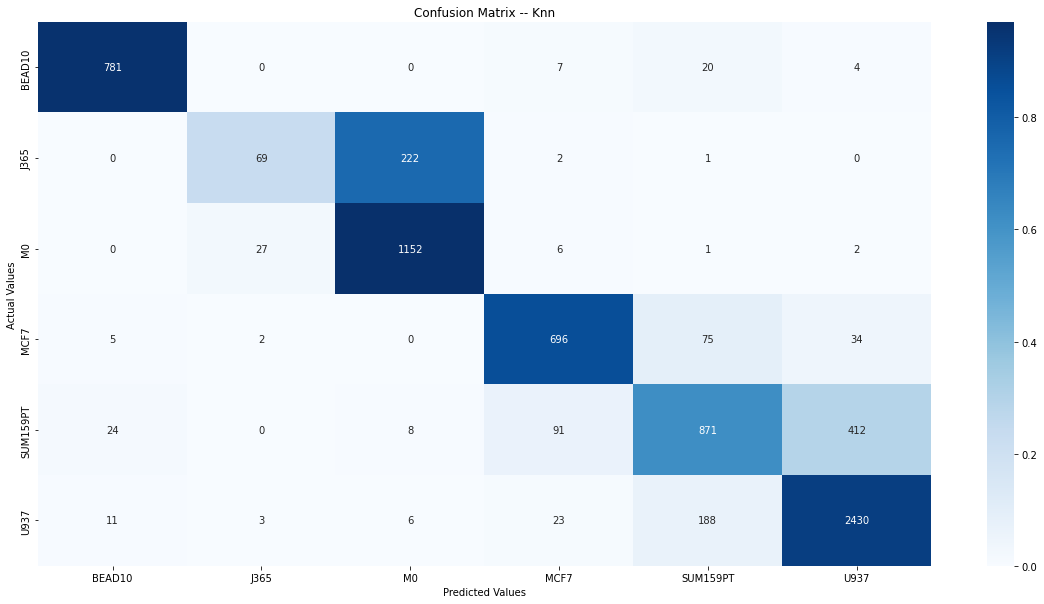


Best param : {'algorithm': 'auto', 'n_neighbors': 12, 'weights': 'distance'}
Prediction time : 0.06148
Accuracy : 0.836330684511362

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       812
           1       0.68      0.23      0.35       294
           2       0.83      0.97      0.89      1188
           3       0.84      0.86      0.85       812
           4       0.75      0.62      0.68      1406
           5       0.84      0.91      0.88      2661

    accuracy                           0.84      7173
   macro avg       0.82      0.76      0.77      7173
weighted avg       0.83      0.84      0.83      7173




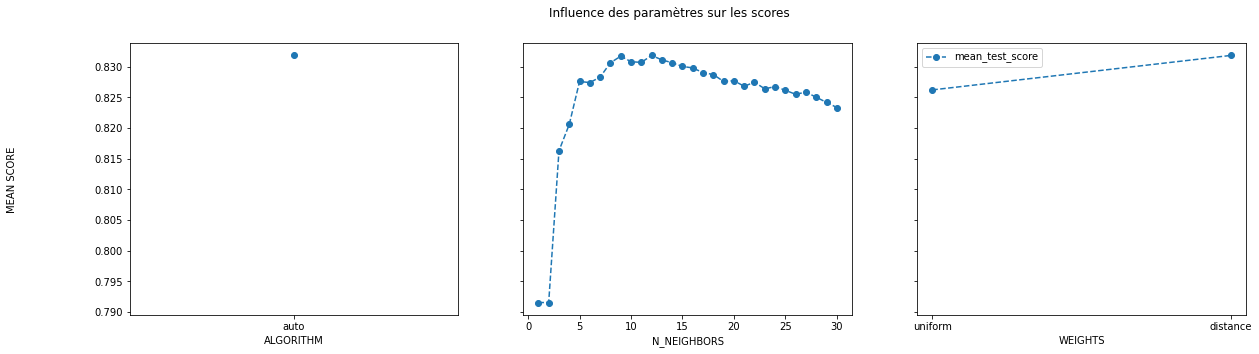

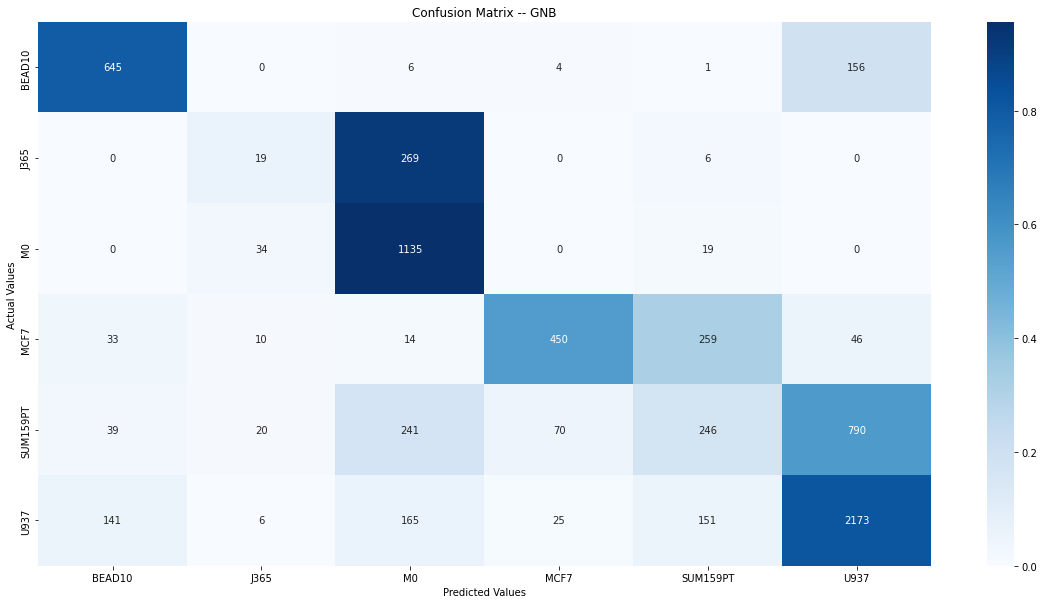


Best param : {'var_smoothing': 0.0035938136638046293}
Prediction time : 0.00328
Accuracy : 0.6507737348389795

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       812
           1       0.21      0.06      0.10       294
           2       0.62      0.96      0.75      1188
           3       0.82      0.55      0.66       812
           4       0.36      0.17      0.24      1406
           5       0.69      0.82      0.75      2661

    accuracy                           0.65      7173
   macro avg       0.58      0.56      0.54      7173
weighted avg       0.61      0.65      0.61      7173




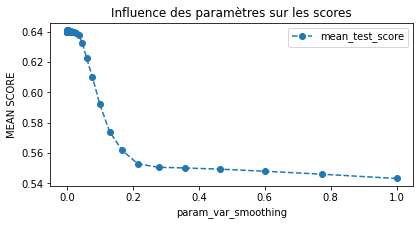

In [ ]:
print_model_train(list_model_train)